# Exploring multitude of scenarios offshore

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import os
import itertools
import time
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import geopandas as gpd
import windfarmer.sdk

### This is how we hook up windfarmer to the python execution environment

In [ ]:
windfarmer_installation_folder = r'C:\Program Files\DNV\WindFarmer - Analyst 1.5.4'
wf = windfarmer.sdk.Sdk(windfarmer_installation_folder)
print(' > SDK is now up and running!')

# Helper function need to be initialized after SDK as they depend on it
from helper_functions import *

 > SDK is now up and running!


### First step is the same as in the GUI: opening the Offshore Demo Workbook

In [7]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
workbook_path = os.path.join(root_dir, 'DemoData', 'OffshoreDemo', 'OffshoreDemoAutomationExample.wwx')

# This is equivalent to opening the workbook in the desktop application
wf.Toolbox.OpenWorkbook(workbook_path)

Let's use `geopandas` to inspect the lease areas and derive centerpoints for each 

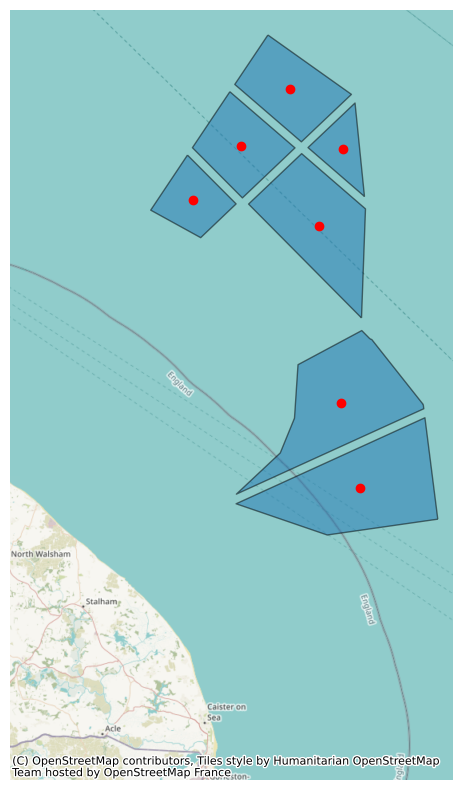

In [8]:
# load the lease areas into a GeoDataFrame
lease_areas = gpd.read_file(os.path.join(os.path.dirname(workbook_path),'gis','proposed_lease_areas_singlepart.shp'))
lease_areas.set_index("name", inplace=True) 
# "target" is the extension project with a fixed layout, so we exclude it from scripted layout generation that follows
lease_areas.drop("target", axis=0, inplace=True) 
# let's see if we have the right shapefile!
plot_lease_area(lease_areas)

### We need to genereate the possible combinations and specify the turbine type

In [9]:
# recursively generate all the possible combinations for the build out cases
combinations = list(itertools.product([True, False], repeat=7))
print("A dataframe of all the possible build-out combinations generated:\n")
print(pd.DataFrame(combinations, columns=lease_areas.index))

# set a cap value high enough to fill any of the lease areas
rating = 3000.0 
# set the turbine type
turbine_type_name = "Bladed Concept Model 19-MW 265-D Offshore"

# remaining layout generation parameters (spacing in particualar) are taken from the workbook 

A dataframe of all the possible build-out combinations generated:

name  lease_5  lease_1  lease_6  lease_2  lease_3  lease_4  lease_7
0        True     True     True     True     True     True     True
1        True     True     True     True     True     True    False
2        True     True     True     True     True    False     True
3        True     True     True     True     True    False    False
4        True     True     True     True    False     True     True
..        ...      ...      ...      ...      ...      ...      ...
123     False    False    False    False     True    False    False
124     False    False    False    False    False     True     True
125     False    False    False    False    False     True    False
126     False    False    False    False    False    False     True
127     False    False    False    False    False    False    False

[128 rows x 7 columns]


### The core logic
 - loop through build-out scenarios
 - design layouts on each lease area
 - calculate external wake efficiency of the "target" farm

In [10]:
results = pd.DataFrame(columns=list(lease_areas.index) + ["Full Yield [GWh/yr]", "External wake efficiency [%]"])
results = results.astype({'Full Yield [GWh/yr]': 'float', 'External wake efficiency [%]': 'float'})
results = results.astype(dict(zip(lease_areas.index, [bool]*len(lease_areas.index))))
i=0
stop_at = 2 #len(lease_areas[index])

# outer loop iterating over the possible build-out scenarios
for combination in combinations[:stop_at]:
    print ("Processing scenario {}".format(i))
    include_farms = dict(zip(lease_areas.index, combination))
    # inner loop iterating over lease areas
    for area in lease_areas.iterrows():
        name = area[0]
        center = area[1].geometry.centroid
        # delete existing turbines on that lease area
        check_neighbour_exists_and_delete_existing_turbines(wf, name)
        if include_farms[name]:
            print("\tGenerating layout at:{}".format(name))
            # When building we can only have the corresponding buildable area
            list_other_regions = get_and_remove_other_buildable_areas(wf, name)
            # Build a close packed layout
            turbine_type = wf.Workbook.TurbineTypes[turbine_type_name]
            wf.Toolbox.Log("Creating farm {} with {} turbines of type {}".format(name, int(rating / (turbine_type.RatedPower/1e6)), turbine_type.Name))
            wf.Toolbox.GenerateClosePackedLayout(
                wf.Workbook.WindFarms[name], #wind farm names coincide with lease area names
                turbine_type, int(rating / (turbine_type.RatedPower/1e6)), # cap on installed capacity on that lease area
                wf.Scripting.Location(center.x, center.y), True) # centerpoint of the grid (lease area specific)
            # Add the remaining regions back to the workbook
            for reg in list_other_regions:
                wf.Workbook.InclusionRegions.Add(reg)
                time.sleep(1)
            
    # Calculate Energy with new neighbours
    print("Evaluating wakes for scenario {}".format(i))
    scenario = wf.Toolbox.CalculateEnergy()
    
    full_yield = get_full_yield_from_results(wf, scenario)
    external_eff = get_external_wake_efficiency(wf)
    case_results = dict(zip(lease_areas.index, combination))
    case_results["Full Yield [GWh/yr]"] = full_yield
    case_results["External wake efficiency [%]"] = external_eff
    results = pd.concat([results,pd.DataFrame(case_results, index=[0])],axis=0)
    results.to_csv("./results.csv")
    i+=1

Processing scenario 0
	Generating layout at:lease_5
	Generating layout at:lease_1
	Generating layout at:lease_6
	Generating layout at:lease_2
	Generating layout at:lease_3
	Generating layout at:lease_4
	Generating layout at:lease_7
Evaluating wakes for scenario 0
Processing scenario 1
	Generating layout at:lease_5
	Generating layout at:lease_1
	Generating layout at:lease_6
	Generating layout at:lease_2
	Generating layout at:lease_3
	Generating layout at:lease_4
Evaluating wakes for scenario 1


### Let's draw some conclusions!

     lease_5  lease_1  lease_6  lease_2  lease_3  lease_4  lease_7  Full Yield [GWh/yr]  External wake efficiency [%]
0       True     True     True     True     True     True     True          4225.686851                      0.920301
1       True     True     True     True     True     True    False          4228.923035                      0.921006
2       True     True     True     True     True    False     True          4277.209326                      0.931522
3       True     True     True     True     True    False    False          4290.935763                      0.934512
4       True     True     True     True    False     True     True          4342.290057                      0.945696
..       ...      ...      ...      ...      ...      ...      ...                  ...                           ...
123    False    False    False    False     True    False    False          4360.144137                      0.949585
124    False    False    False    False    False     Tru

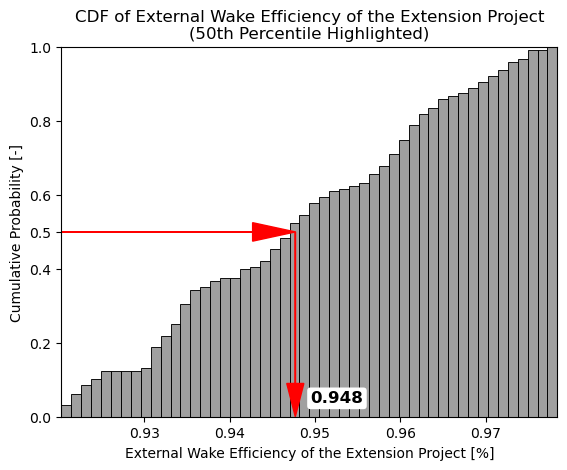

P50 assumption on external wake efficiency during the first year of wind farm operation: 0.95


In [11]:
p50_external_wake_efficiency = plot_cumulative_dist('./results_full.csv')
print("P50 assumption on external wake efficiency during the first year of wind farm operation: {}".format(round(p50_external_wake_efficiency,2)))

### And close the workbook

In [12]:
wf.Toolbox.NewWorkbook()